In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
# matplotlib.rcParams['figure.figsize'] = 12, 18

# What is Camera Calibration?

## Camera calibration is the way of computing the particular camera's parameters

#### That helps in
- removing distortion in an image
- depth of the object
- size of the object
- in motion estimation, image stitching and many more!

### Camera Calibration Parameters
#### 1. extrinsic paremeters
Extrinsic parameters helps in finding transformation between 3D world co-rodinates and camera co-ordinates.

#### 2. intrinsic parameters
Intrinsic parameters helps in finding transformation between 3D camera co-ordinates and 2D image plane.


#### List of Extrinsic Parameters 
The extrinsic parameters consist of a rotation, *R*, and a translation, *t*. The origin of the camera’s coordinate system is at its optical center and its x- and y-axis define the image plane.
#### List of Intrinsic Parameters
The intrinsic parameters include the focal length, the optical center, also known as the principal point, and the skew coefficient. The camera intrinsic matrix is defined as:

$$K = \begin{bmatrix}f_{x} & 0 & 0\\s & f_{y} & 0\\c_{x} & c_{y} & 1\end{bmatrix}$$
Camera matrix, P:
$$P = \begin{bmatrix}R\\t\end{bmatrix}K$$

Camara matrix is of size 3 x 4 coonsisting total 12 values in it but camera matrix has only 11 DOF. (and later we will deduce that we need minimum of 6 images to calibrate using planar methods)


The camera matrix does not account for lens distortion because an ideal pinhole camera does not have a lens. To accurately represent a real camera, the camera model includes the **radial** and **tangential** lens distortion.

### Radial distortion
Due to radial distortion, straight lines will appear curved. Its effect is more as we move away from the center of image. Radial distortion occurs when light rays bend more near the edges of a lens than they do at its optical center. The smaller the lens, the greater the distortion.
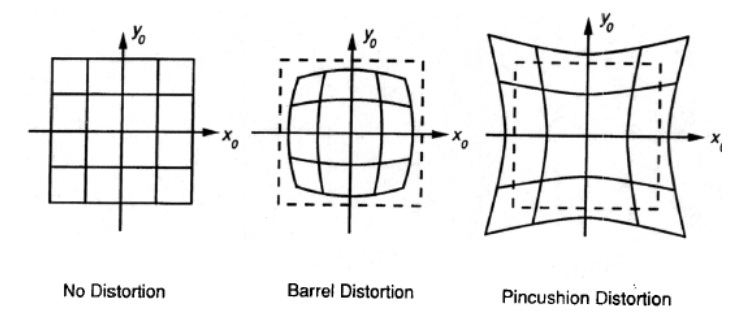
$$x_{distorted} = x(1 + k_{1}r^{2} + k_{2}r^{4} + k_{3}r^{6})$$
$$y_{distorted} = y(1 + k_{1}r^{2} + k_{2}r^{4} + k_{3}r^{6})$$
where x and y are undistorted pixel locations, k1, k2 and k3 are radial distortion coefficients of lens. Typically, two constants(k1 and k2) are enough.

### Tangential distortion
Tangential distortion occurs when the lens and the image plane are not parallel. So some areas in image may look nearer than expected.
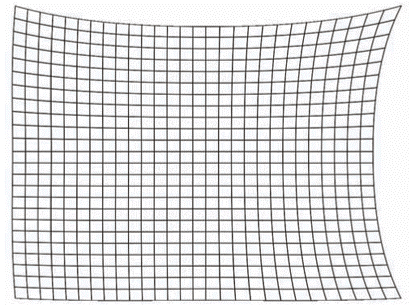
$$x_{distorted} = x + 2p_{1}xy + p_{2}(r^{2} + 2x^{2})$$
$$y_{distorted} = y + p_{1}(r^{2} + 2y^{2}) + 2p_{2}xy$$ 

## what we need to find these values?




## we can calibrate using...
#### Chessboard (Recommended)
Chessboard patterns are by far the most popular. There is good reason for this, their corners are simple to detect and "mostly" invariant to lens distortion. The main disadvantage to chessboard is that its hard get right next to the image border, but you can get close!
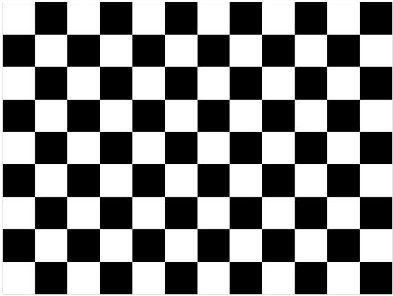
#### Square Grids
Square Grids allow  you to get right up next to the image border. It's more complex for a library developer to write a good high precision unbiased corner. BoofCV does an extra step of refinement that enable very high precision corners to be found. However, the current approach is less accurate under fisheye lens distortion.
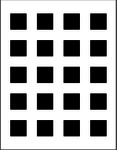
#### Circle Hexagonal
Circle Hexagonal works well for regular camera lenses but is typically less accurate than chessboard of square grid because their features can't be measured directly. Tangent points are invariant under perspective distortion. Sometimes a library will use the center point, but this is ill advised because it's not invariant under perspective distortion. Errors introduced by lens distortion are less significant when the circles are small inside the image, but under heavy lens distortion these are a poor choice.

#### Circle Regular Grid
Circle Regular Grid have essentially the same pros/cons as circle hexagonal but don't have the same circle density.
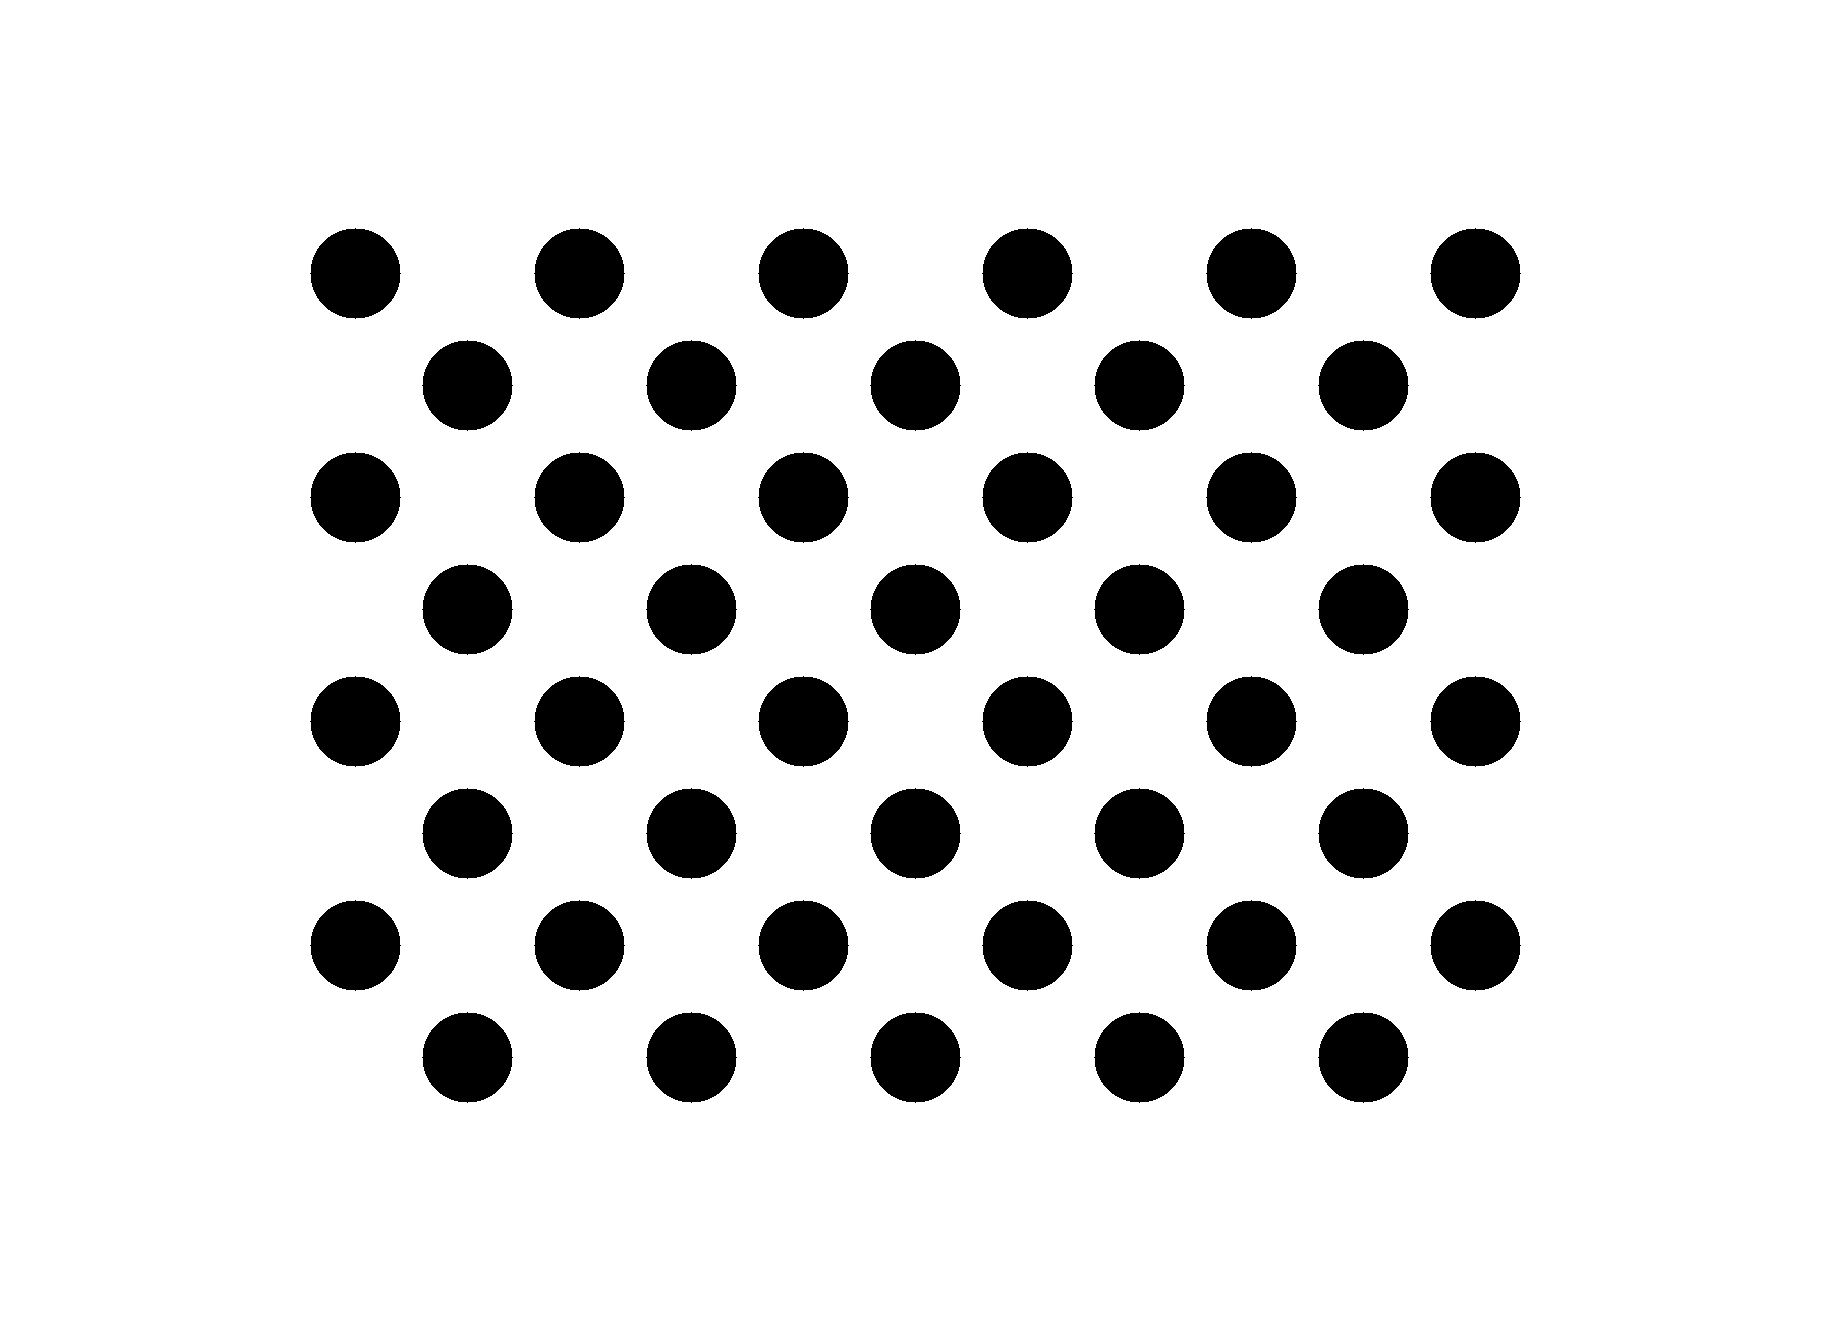

## let's do it!

### Goal 1: Find points(corners)

In [2]:
# Define No of corners 
# don's count black and white squares
# count intersection in length and width

length = 6
width = 9

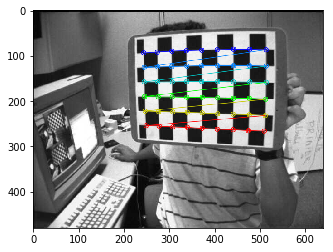

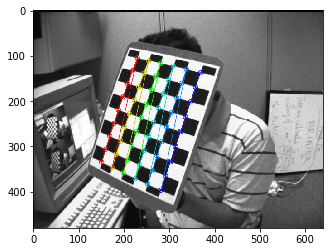

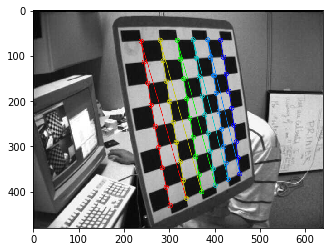

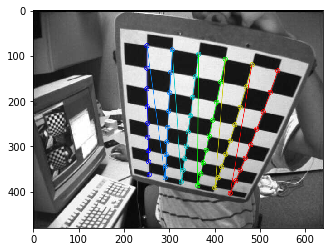

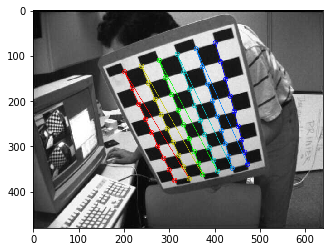

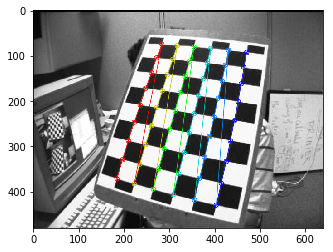

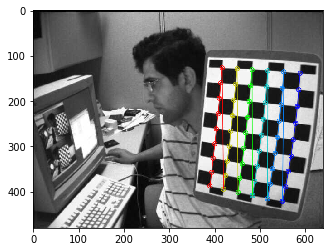

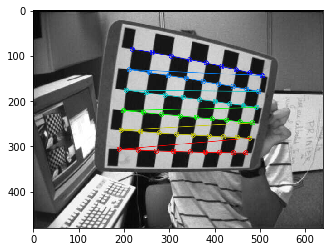

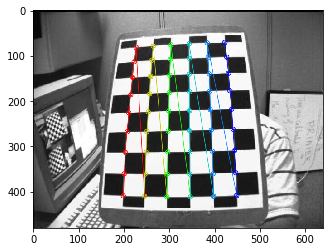

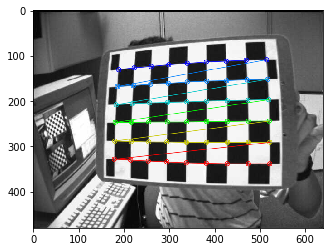

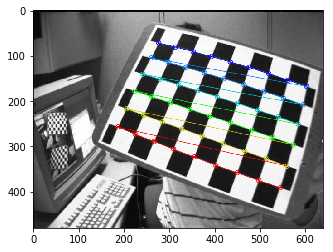

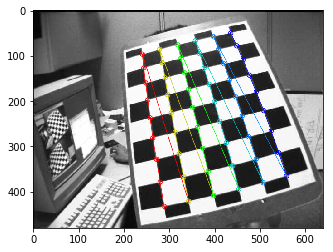

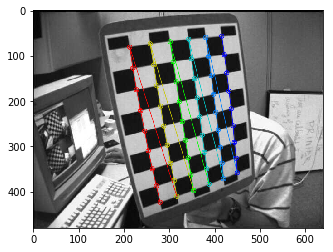

In [3]:
import glob

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((length * width, 3), np.float32)
objp[:, :2] = np.mgrid[0:width, 0:length].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = []  # 3d point in real world space
imgpoints = []  # 2d points in image plane.

images = glob.glob('data/*.jpg')
outs = []

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (width, length),None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray, corners, (11, 11),(-1, -1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (width, length), corners2, ret)
        outs.append(img)

total = len(outs)
for i, out in enumerate(outs):
    try:
#         plt.subplot(total // 2, 2, i + 1)
        plt.imshow(out)
        plt.show()
    except: break

### Goal 2: Find Camera matrix

In [4]:
# find camera matrix, distorition coefficients etc
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Now we can undistort our image
img = cv2.imread("data/left12.jpg")
h, w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
x, y, w, h = roi

### Goal 3: Undistort the image

Result using Shortest path undistortion


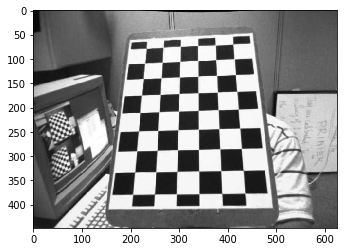

Result using Curved path undistortion


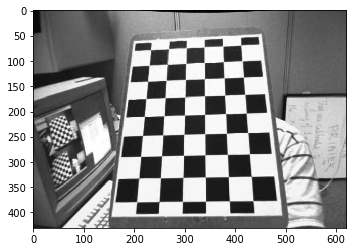

In [5]:
# 2 ways of undistort
# 1. Shortest path undistortion
out1 = cv2.undistort(img, mtx, dist, None, newcameramtx)
out1 = out1[y:y + h, x:x + w]
print("Result using Shortest path undistortion")
plt.imshow(out1)
plt.show()

# 2. Curved path, find mapping from distorted to undistorted image
mapx, mapy = cv2.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w, h), 5)
out2 = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)
out2 = out2[y:y + h, x:x + w]
print("Result using Curved path undistortion")
plt.imshow(out2)
plt.show()

In [6]:
print("camera matrix",mtx,"\n")
print("Distortion",dist)

camera matrix [[536.07343678   0.         342.37038244]
 [  0.         536.01635208 235.53685415]
 [  0.           0.           1.        ]] 

Distortion [[-0.26509011 -0.04674355  0.00183301 -0.00031471  0.25231509]]


In [7]:
# Reprojection error to find accuracy of estimated parameters
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2) / len(imgpoints2)
    mean_error += error

print("total error: %.4f %%" % (mean_error / len(objpoints)))

total error: 0.0410 %


## Let's do some cool stuff!

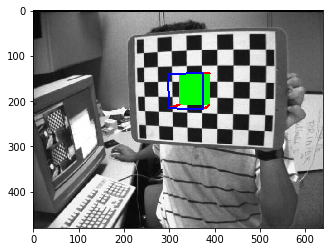

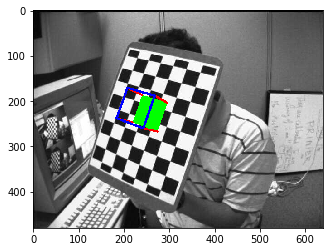

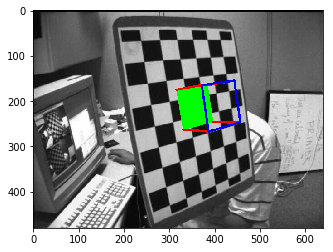

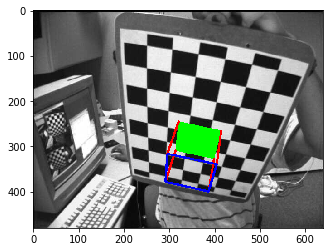

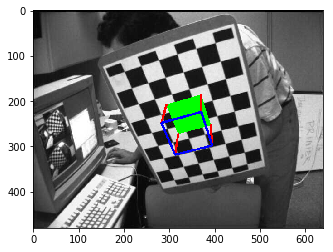

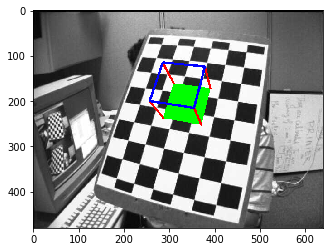

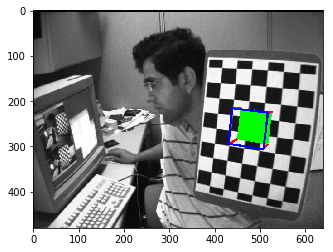

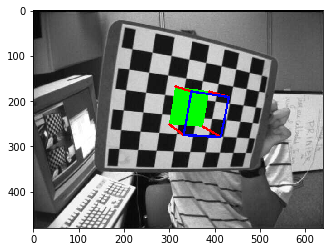

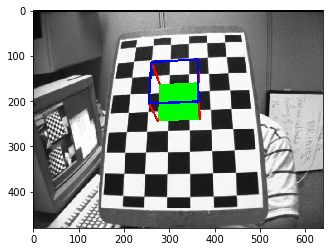

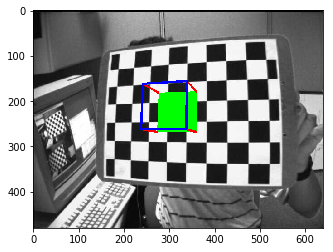

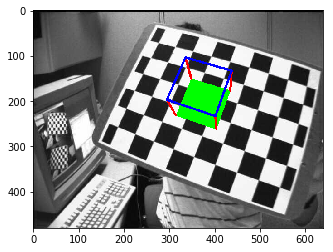

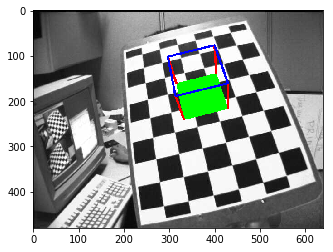

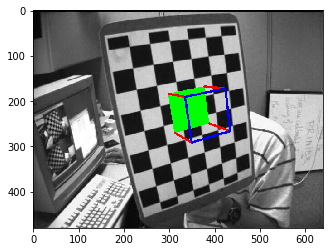

In [8]:
def draw(img, corners, imgpts):
    imgpts = np.int32(imgpts).reshape(-1, 2)

    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]], -1, (0, 255, 0), -3)

    # draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]), (255), 3)

    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]], -1, (0, 0, 255), 3)

    return img

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((length * width, 1, 3), np.float32)
objp[:, :, :2] = np.mgrid[0:width, 0:length].T.reshape(-1, 1, 2)

offset = [2.5, 1.5,0]
size = 2

# PS: The sequence of the points matters!
# and also axis is not axis it is just points!!!
axis = np.float32([[0, 0, 0], [0, size, 0], [size, size, 0], [size, 0, 0],
                   [0, 0, -1*size],[0, size, -1*size],[size, size, -1*size],[size, 0, -1*size]])

axis = axis + offset
outs = []

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (width, length),None)

    if ret == True:
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

        # Find the rotation and translation vectors.
        _, rvecs, tvecs, inliers = cv2.solvePnPRansac(objp, corners2, mtx, dist)

        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)
        
        img = draw(img, corners2, imgpts)
        outs.append(img)

for i, out in enumerate(outs):
    try:
        plt.imshow(out)
        plt.show()
    except: break